In [1]:
# --> Install necessary packages
!pip install --quiet -U "wandb" "lightning" "ptflops"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.9/827.9 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import gc
import time
import random
import wandb
import subprocess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightning as L
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torchmetrics import Accuracy, F1Score
from torchmetrics import MetricCollection
from PIL import Image
from torchvision import transforms as T, datasets
from types import SimpleNamespace
from torch.utils.data import random_split, DataLoader, Dataset
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import WandbLogger, CSVLogger
from lightning.pytorch import LightningDataModule
from sklearn.model_selection import train_test_split
from kaggle_secrets import UserSecretsClient
from ptflops import get_model_complexity_info

In [3]:
L.seed_everything(42)
NUM_WORKERS = os.cpu_count()

# Testing dataset
# DATASET_NORMAL_PATH= "/kaggle/input/daisee-conf-det-dummy/cnn_dataset_normal-20251113T104849Z-1-001/cnn_dataset_normal/train"
# DATASET_UNDERSAMPLING_PATH= "/kaggle/input/daisee-conf-det-dummy/cnn_dataset_undersampling-20251113T104849Z-1-001/cnn_dataset_undersampling/train"

# Should be adjusted for the end-to-end experiment
DATASET_NORMAL_PATH = "/kaggle/input/cnn-dataset-oversampling/cnn_dataset_normal/train"
DATASET_UNDERSAMPLING_PATH = "/kaggle/input/cnn-dataset-oversampling/cnn_dataset_undersampling/train"
DATASET_OVERSAMPLING_PATH = "/kaggle/input/cnn-dataset-oversampling/cnn_dataset_oversampling/train"

Seed set to 42


### WOrktable

In [4]:
class ImagePathDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

In [5]:
class DAiSEECDM(L.LightningDataModule):
    def __init__(self, 
                 data_dir: str = None,
                 batch_size: int = 32,
                 num_workers: int = 4,
                 val_split: float = 0.2,
                 img_size: int = 32,
                 seed:int = 42):
        
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.seed = seed
        self.img_size = img_size

        self.test_transform = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        self.train_transform = T.Compose([
            T.Resize((224, 224)),
            T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.02),
            T.RandomApply([T.GaussianBlur(kernel_size=3)], p=0.2),
            T.RandomApply([T.RandomGrayscale(p=1.0)], p=0.1),
            T.RandomAffine(
                degrees=3, 
                translate=(0.05, 0.05),
                scale=(0.95, 1.05),
                shear=None
            ),
            T.RandomPerspective(distortion_scale=0.05, p=0.3),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def setup(self, stage=None):
        self.full_dataset = datasets.ImageFolder(self.data_dir)
        self.paths = [sample[0] for sample in self.full_dataset.imgs]
        self.labels = [sample[1] for sample in self.full_dataset.imgs]

        train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
            self.paths, self.labels, test_size=0.2, stratify=self.labels, random_state=42
        )
        
        train_paths, val_paths, train_labels, val_labels = train_test_split(
            train_val_paths, train_val_labels, test_size=0.25, stratify=train_val_labels, random_state=42
        )
            
        if stage == "fit":
            self.train_dataset = ImagePathDataset(train_paths, train_labels, transform=self.train_transform)
            self.val_dataset = ImagePathDataset(val_paths, val_labels, transform=self.test_transform)
            
        if stage == "test":
            self.test_dataset = ImagePathDataset(test_paths, test_labels, transform=self.test_transform)
            
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, pin_memory=True,num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, pin_memory=True,num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, pin_memory=True,num_workers=self.num_workers)

In [6]:
try:
    dm_normal = DAiSEECDM(data_dir=DATASET_NORMAL_PATH)
    dm_under = DAiSEECDM(data_dir=DATASET_UNDERSAMPLING_PATH)
    dm_over = DAiSEECDM(data_dir=DATASET_OVERSAMPLING_PATH)
except Exception as e:
    print(f"An error occured: {type(e).__name__} – {e}")
    pass

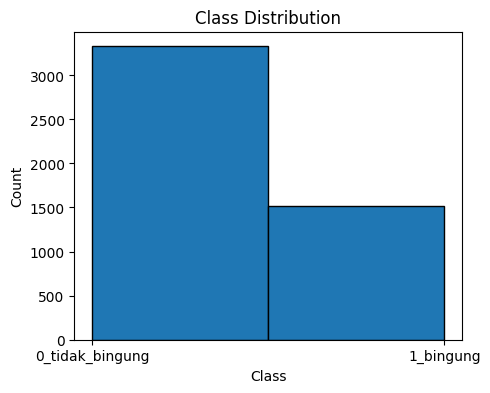

In [7]:
# Cheking sanity
dm = dm_normal
dm.prepare_data()
dm.setup(stage="fit")
class_names = dm.full_dataset.classes

# print(f"Train size: {len(dm.train_dataset)}")
# print(f"Val size: {len(dm.val_dataset)}")
# print(f"Num of classes: {len(class_names)}\nClasses: {class_names}")
# print(f"Classes: {dm.train_dataset.labels[:10]}")  # Should be 0s and 1s

# train_loader = dm.train_dataloader()
# # val_loader = dm.val_dataloader()

# batch = next(iter(train_loader))
# print(type(batch), len(batch))
# print(batch[0].shape, batch[1].shape)


# imgs, labels = next(iter(dm.train_dataloader()))
# print(imgs.mean(), imgs.std())

plt.figure(figsize=(5, 4))
plt.hist(dm.labels, bins=len(class_names), edgecolor='black')
plt.xticks(np.arange(len(class_names)), class_names)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

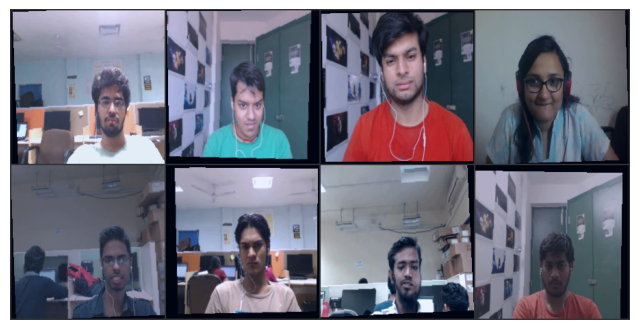

In [8]:
NUM_IMGS = 8
images = torch.stack([dm.train_dataset[idx][0] for idx in range(NUM_IMGS)])
grid = torchvision.utils.make_grid(images, nrow=4, normalize=True, pad_value=0.2)
plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1, 2, 0))
# plt.title(class_names[labels])
plt.axis("off")
plt.show()

## Model Initialization

In [9]:
class EEffModelTF(nn.Module):
    def __init__(self, num_classes=2, c_t=512, act_fn=nn.SiLU, dropout=0.2):
        super().__init__()
        self.base = torchvision.models.efficientnet_b0(weights='DEFAULT')
        self.base.classifier = nn.Identity() # --> acts as a placeholder that effectively "removes" a layer's functionality while maintaining the structural integrity of the nn.Module hierarchy
        self.fc = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(1280, c_t),
            act_fn(),
            nn.Dropout(p=dropout),
            nn.Linear(c_t,c_t//2),
            act_fn(),
            nn.Dropout(p=dropout),
            nn.Linear(c_t//2,num_classes),
        )

    def forward(self, x):
        x = self.base(x)
        x = self.fc(x)
        return x

In [10]:
class DCDModule(L.LightningModule):
    def __init__(self,
                 model_name: str,
                 model_hparams: dict,
                 optimizer_name: str,
                 optimizer_hparams: dict):
        super().__init__()
        self.save_hyperparameters(ignore=['large_object']) if hasattr(self, 'save_hyperparameters') else None
        self.model = EEffModelTF(**model_hparams)

        self.task = "binary"
        self.num_classes = None if self.task == "binary" else model_hparams.get('num_classes')
        self.loss_fn = nn.BCEWithLogitsLoss() if self.task == "binary" else nn.CrossEntropyLoss()
        metric_args = {"task": self.task, "num_classes": self.num_classes}
        self.metrics = MetricCollection({
            "train_acc": Accuracy(**metric_args),
            "val_acc": Accuracy(**metric_args),
            "val_f1": F1Score(**metric_args, average='macro'),
            "test_acc": Accuracy(**metric_args),
            "test_f1_macro": F1Score(**metric_args, average='macro'),
            "test_f1_weighted": F1Score(**metric_args, average='weighted'),
        })
        
    def on_fit_start(self):
        self.metrics = self.metrics.to(self.device)

    def forward(self, imgs):
        return self.model(imgs)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), **self.hparams.optimizer_hparams)
        scheduler = {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode="min", factor=0.1, patience=10
            ),
            "monitor": "val_loss", 
        }
        return [optimizer], [scheduler]

    def _process_batch(self, batch):
        x, y = batch
        if self.task == "binary":
            y = y.float().unsqueeze(1)
        probs = self(x)
        return x, y , probs

    def _shared_step(self, batch, step_type: str):
        """Shared logic for training/validation/test steps"""
        x, y, preds = self._process_batch(batch)
        loss = self.loss_fn(preds, y)
        
        self.log(f"{step_type}_loss", loss, prog_bar=True)
        
        # Log metrics for validation and test
        if step_type in ["val", "test"]:
            acc = self.metrics[f"{step_type}_acc"](preds, y)
            self.log(f"{step_type}_acc", acc, prog_bar=True)
            
            if step_type == "val":
                f1 = self.metrics["val_f1"](preds, y)
                self.log("val_f1", f1, prog_bar=True)
            else:  # test
                f1_macro = self.metrics["test_f1_macro"](preds, y)
                f1_weighted = self.metrics["test_f1_weighted"](preds, y)
                self.log("test_f1_macro", f1_macro)
                self.log("test_f1_weighted", f1_weighted)
        
        return loss if step_type == "train" else None

    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        self._shared_step(batch, "val")
    
    def test_step(self, batch, batch_idx):
        self._shared_step(batch, "test")

## Single Run

In [11]:
def train_experiment(model_name, 
                     dataset_name, 
                     optimizer_name, 
                     model_hparams, 
                     optimizer_hparams,
                     data_module,
                     seed=42,
                     max_epochs=100):
    
    L.seed_everything(seed)
    experiment_name = f"{model_name}_{dataset_name}_{optimizer_name}_seed{seed}"
    try:
        logger = WandbLogger(
            offline=True,
            name=experiment_name,
            project="ACRIG-DAiSEE-binary_confusion_detection",
            config={
                "model_name": model_name,
                "dataset_name": dataset_name,
                "optimizer_name": optimizer_name,
                "model_hparams": model_hparams,
                "optimizer_hparams": optimizer_hparams,
                "seed": seed,
                "max_epochs": max_epochs,
            },
        )
        print("WandB logger initialized successfully")
    except Exception as e:
        print(f"WandB Logger failed: {e}")
        print("Falling back to CSV logger")
        logger = CSVLogger(
            save_dir="logs",
            name=experiment_name
        )

    model = DCDModule(
        model_name=model_name,
        model_hparams=model_hparams,
        optimizer_name=optimizer_name,
        optimizer_hparams=optimizer_hparams
    )
    
    trainer = L.Trainer(
        default_root_dir=f"checkpoints/{experiment_name}",
        accelerator="auto",
        devices=1,
        max_epochs=max_epochs,
        logger=logger,
        callbacks=[
            ModelCheckpoint(
                save_weights_only=True, 
                mode="max", 
                monitor="val_acc",
                dirpath=f"checkpoints/{experiment_name}",
                filename="best-checkpoint",
            ),
            LearningRateMonitor("epoch"),
            EarlyStopping(monitor="val_loss", mode="min", patience=10),
        ],
        log_every_n_steps=10,
    )

    trainer.fit(model, datamodule=data_module)

    try:
        macs, params = get_model_complexity_info(
            model.model, 
            (3, 224, 224),
            as_strings=False,
            print_per_layer_stat=False,
            verbose=False
        )
        fwd_flops = macs * 2  
        num_params = params
    except:
        fwd_flops = 0
        num_params = sum(p.numel() for p in model.parameters())

    test_results = trainer.test(model, datamodule=data_module)

    if test_results and len(test_results) > 0:
        test_result = test_results[0]
        test_acc = test_result.get('test_acc', 0.0)
        test_f1_macro = test_result.get('test_f1_macro', 0.0)
        test_f1_weighted = test_result.get('test_f1_weighted', 0.0)
    else:
        test_acc = test_acc_top5 = test_f1_macro = test_f1_weighted = 0.0

    model.eval()
    latencies = []
    test_loader = data_module.test_dataloader()
    num_batches = min(50, len(test_loader))
    
    device = next(model.parameters()).device
    
    with torch.inference_mode():
        for i, (x, _) in enumerate(test_loader):
            if i >= num_batches:
                break
            x = x.to(device)
            if device.type == "cuda":
                torch.cuda.synchronize()
            start = time.perf_counter()
            _ = model(x)
            if device.type == "cuda":
                torch.cuda.synchronize()
            end = time.perf_counter()
            latencies.append((end - start) / x.size(0))
    
    avg_latency_ms = np.mean(latencies) * 1000 if latencies else float('nan')

    if hasattr(logger, 'experiment') and logger.experiment is not None:
        try:
            metrics_to_log = {
                "num_parameters": num_params,
                "avg_inference_latency_ms": avg_latency_ms,
                "test_acc": test_acc,
                "test_f1_macro": test_f1_macro,
                "test_f1_weighted": test_f1_weighted,
            }
            if fwd_flops > 0:
                metrics_to_log["flops"] = fwd_flops
                
            logger.experiment.log(metrics_to_log)
            logger.experiment.finish()
            print(f"Successfully finished WandB run: {experiment_name}")
        except Exception as e:
            print(f"Failed to finish WandB run: {e}")
    elif 'CSVLogger' in str(type(logger)):
        # Log to CSV as well
        final_metrics = {
            "final_num_parameters": num_params,
            "final_avg_inference_latency_ms": avg_latency_ms,
        }
        if fwd_flops > 0:
            final_metrics["final_flops"] = fwd_flops
        logger.log_metrics(final_metrics)

    wandb.finish()

    return {
        "test_acc": test_acc,
        "test_f1_macro": test_f1_macro,
        "test_f1_weighted": test_f1_weighted,
        "model_metrics": {
            "num_params": num_params,
            "flops": fwd_flops,
            "avg_inference_time": np.mean(latencies) if latencies else float('nan'),
        }
    }

## Multiple runs

In [12]:
def run_all_experiments(epochs=10):
    experiments = [
        {
            "model_name": "effnetb0-binary",
            "dataset_name": "normal", 
            "data_module": dm_normal,
            "model_hparams": {"num_classes": 1},
            "optimizer_hparams": {"lr": 1e-3, "weight_decay": 1e-4}
        },
        {
            "model_name": "effnetb0-binary",
            "dataset_name": "under", 
            "data_module": dm_under,
            "model_hparams": {"num_classes": 1},
            "optimizer_hparams": {"lr": 1e-3, "weight_decay": 1e-4}
        },
        {
            "model_name": "effnetb0-binary", 
            "dataset_name": "over",
            "data_module": dm_over,
            "model_hparams": {"num_classes": 1},
            "optimizer_hparams": {"lr": 1e-3, "weight_decay": 1e-4}
        }
    ]
    
    results = {}
    for exp_config in experiments:
        print(f"\n{'='*50}")
        print(f"Starting experiment: {exp_config['model_name']} on {exp_config['dataset_name']}")
        print(f"{'='*50}")
        
        result = train_experiment(
            model_name=exp_config["model_name"],
            dataset_name=exp_config["dataset_name"],
            optimizer_name="Adam",
            model_hparams=exp_config["model_hparams"],
            optimizer_hparams=exp_config["optimizer_hparams"],
            data_module=exp_config["data_module"],
            seed=42,
            max_epochs=epochs
        )
        
        results[f"{exp_config['model_name']}_{exp_config['dataset_name']}"] = result
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
    
    return results

In [13]:
run_all_experiments(epochs=20)

Seed set to 42



Starting experiment: effnetb0-binary on normal
WandB logger initialized successfully


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 69.0MB/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
wandb: WARNING `resume` will be ignored since W&B syncing is set to `offline`. Starting a new run with run id xy948tgf.
wandb: Tracking run with wandb version 0.23.0
wandb: W&B syncing is set to `offline` in this directory. Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.
wandb: Run data is saved locally in ./wandb/offline-run-20251120_025650-xy948tgf
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | EEffModelTF       | 4.8 M  | train
1 | loss_fn | BCEWithLogitsLoss | 0      | train
2 | metrics | MetricCollection  | 0      | train
------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7003089785575867     │
│       test_f1_macro       │    0.09929167479276657    │
│     test_f1_weighted      │    0.09929167479276657    │
│         test_loss         │    0.5944153070449829     │
└───────────────────────────┴───────────────────────────┘

wandb: 
wandb: Run history:
wandb: avg_inference_latency_ms ▁
wandb:                    epoch ▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
wandb:                    flops ▁
wandb:                  lr-Adam ▁▁▁▁▁▁▁▁▁▁▁
wandb:           num_parameters ▁
wandb:                 test_acc ▁▁
wandb:            test_f1_macro ▁▁
wandb:         test_f1_weighted ▁▁
wandb:                test_loss ▁
wandb:               train_loss ▆▃▅▃▂▅▃▄▅▁▆▅▂▂▁▃▅▆▄▄▅▄▄█▂▄▁▃▄▆▄▂▄▄▄▄█▆▁▃
wandb:                       +4 ...
wandb: 
wandb: Run summary:
wandb: avg_inference_latency_ms 51.82236
wandb:                    epoch 11
wandb:                    flops 819408242
wandb:                  lr-Adam 0.001
wandb:           num_parameters 4795005
wandb:                 test_acc 0.70031
wandb:            test_f1_macro 0.09929
wandb:         test_f1_weighted 0.09929
wandb:                test_loss 0.59442
wandb:               train_loss 0.56969
wandb:                       +4 ...
wandb: 
wandb: You can sync this run to the c

Successfully finished WandB run: effnetb0-binary_normal_Adam_seed42


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
wandb: WARNING `resume` will be ignored since W&B syncing is set to `offline`. Starting a new run with run id 8ais0mi3.



Starting experiment: effnetb0-binary on under
WandB logger initialized successfully


wandb: Tracking run with wandb version 0.23.0
wandb: W&B syncing is set to `offline` in this directory. Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.
wandb: Run data is saved locally in ./wandb/offline-run-20251120_030206-8ais0mi3
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | EEffModelTF       | 4.8 M  | train
1 | loss_fn | BCEWithLogitsLoss | 0      | train
2 | metrics | MetricCollection  | 0      | train
------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.180    Total estimated model params size (MB)
353       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6417197585105896     │
│       test_f1_macro       │    0.5901552438735962     │
│     test_f1_weighted      │    0.5901552438735962     │
│         test_loss         │    0.6537876725196838     │
└───────────────────────────┴───────────────────────────┘

wandb: 
wandb: Run history:
wandb: avg_inference_latency_ms ▁
wandb:                    epoch ▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█
wandb:                    flops ▁
wandb:                  lr-Adam ▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:           num_parameters ▁
wandb:                 test_acc ▁▁
wandb:            test_f1_macro ▁▁
wandb:         test_f1_weighted ▁▁
wandb:                test_loss ▁
wandb:               train_loss ▅▆▅▅▅▅▅▅▄▆▃▃▆▇▄▄▆▅▄▆▄▄█▅▄▃▂▇▅▄▄▆▅▃▁▅▅▃▆▅
wandb:                       +4 ...
wandb: 
wandb: Run summary:
wandb: avg_inference_latency_ms 51.27021
wandb:                    epoch 14
wandb:                    flops 819408242
wandb:                  lr-Adam 0.001
wandb:           num_parameters 4795005
wandb:                 test_acc 0.64172
wandb:            test_f1_macro 0.59016
wandb:         test_f1_weighted 0.59016
wandb:                test_loss 0.65379
wandb:               train_loss 0.60746
wandb:                       +4 ...
wandb: 
wandb: You can sync this run to th

Successfully finished WandB run: effnetb0-binary_under_Adam_seed42


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
wandb: WARNING `resume` will be ignored since W&B syncing is set to `offline`. Starting a new run with run id wfijpfdh.



Starting experiment: effnetb0-binary on over
WandB logger initialized successfully


wandb: Tracking run with wandb version 0.23.0
wandb: W&B syncing is set to `offline` in this directory. Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.
wandb: Run data is saved locally in ./wandb/offline-run-20251120_030628-wfijpfdh
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | EEffModelTF       | 4.8 M  | train
1 | loss_fn | BCEWithLogitsLoss | 0      | train
2 | metrics | MetricCollection  | 0      | train
------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.180    Total estimated model params size (MB)
353       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8254685997962952     │
│       test_f1_macro       │    0.8603633642196655     │
│     test_f1_weighted      │    0.8603633642196655     │
│         test_loss         │    0.3549571633338928     │
└───────────────────────────┴───────────────────────────┘

wandb: 
wandb: Run history:
wandb: avg_inference_latency_ms ▁
wandb:                    epoch ▁▁▁▁▁▁▁▂▂▂▂▂▂▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
wandb:                    flops ▁
wandb:                  lr-Adam ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:           num_parameters ▁
wandb:                 test_acc ▁▁
wandb:            test_f1_macro ▁▁
wandb:         test_f1_weighted ▁▁
wandb:                test_loss ▁
wandb:               train_loss █▂▅▃▆▅▅▅▅▆█▆▄▄▄▂▄▇▆▄▄▅▄▆▁▁▄▅▅▄▅▁▃▃▁▆▃▂▃▄
wandb:                       +4 ...
wandb: 
wandb: Run summary:
wandb: avg_inference_latency_ms 536.75034
wandb:                    epoch 20
wandb:                    flops 819408242
wandb:                  lr-Adam 0.001
wandb:           num_parameters 4795005
wandb:                 test_acc 0.82547
wandb:            test_f1_macro 0.86036
wandb:         test_f1_weighted 0.86036
wandb:                test_loss 0.35496
wandb:               train_loss 0.3337
wandb:                       +4 ...
wandb: 
wandb: You can sync this run

Successfully finished WandB run: effnetb0-binary_over_Adam_seed42


{'effnetb0-binary_normal': {'test_acc': 0.7003089785575867,
  'test_f1_macro': 0.09929167479276657,
  'test_f1_weighted': 0.09929167479276657,
  'model_metrics': {'num_params': 4795005,
   'flops': 819408242,
   'avg_inference_time': 0.05182236073469555}},
 'effnetb0-binary_under': {'test_acc': 0.6417197585105896,
  'test_f1_macro': 0.5901552438735962,
  'test_f1_weighted': 0.5901552438735962,
  'model_metrics': {'num_params': 4795005,
   'flops': 819408242,
   'avg_inference_time': 0.05127021364187506}},
 'effnetb0-binary_over': {'test_acc': 0.8254685997962952,
  'test_f1_macro': 0.8603633642196655,
  'test_f1_weighted': 0.8603633642196655,
  'model_metrics': {'num_params': 4795005,
   'flops': 819408242,
   'avg_inference_time': 0.5367503443168744}}}

## Autozip the wandb_logs

In [14]:
!zip -r wandb_logs.zip wandb

  adding: wandb/ (stored 0%)
  adding: wandb/offline-run-20251120_030206-8ais0mi3/ (stored 0%)
  adding: wandb/offline-run-20251120_030206-8ais0mi3/tmp/ (stored 0%)
  adding: wandb/offline-run-20251120_030206-8ais0mi3/tmp/code/ (stored 0%)
  adding: wandb/offline-run-20251120_030206-8ais0mi3/logs/ (stored 0%)
  adding: wandb/offline-run-20251120_030206-8ais0mi3/logs/debug-internal.log (deflated 71%)
  adding: wandb/offline-run-20251120_030206-8ais0mi3/logs/debug.log (deflated 73%)
  adding: wandb/offline-run-20251120_030206-8ais0mi3/logs/debug-core.log (deflated 75%)
  adding: wandb/offline-run-20251120_030206-8ais0mi3/run-8ais0mi3.wandb (deflated 79%)
  adding: wandb/offline-run-20251120_030206-8ais0mi3/files/ (stored 0%)
  adding: wandb/offline-run-20251120_030206-8ais0mi3/files/requirements.txt (deflated 57%)
  adding: wandb/debug-internal.log (deflated 71%)
  adding: wandb/offline-run-20251120_030628-wfijpfdh/ (stored 0%)
  adding: wandb/offline-run-20251120_030628-wfijpfdh/tmp/ (s